<span style="color:orange;font-size:30px">1. Problem definition</span>

The goal of the project is to create a model that can predict who among the Titanic's passengers survived the disaster and who did not.
The assumption is made that this is a classification problem.

<span style="color:orange;font-size:30px">2. Data collection</span>

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import titanic_tools

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [36]:
titanic_train = pd.read_csv("data/train.csv")
titanic_test = pd.read_csv("data/test.csv")

<span style="color:orange;font-size:30px">3. Data analysis</span>

In [37]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

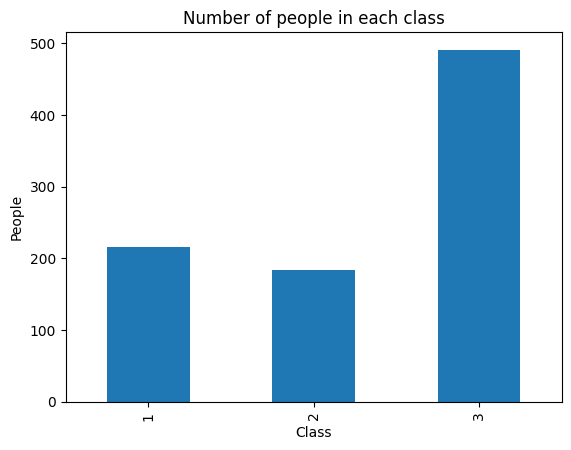

In [40]:
titanic_tools.plot_people_in_each_class(titanic_train)

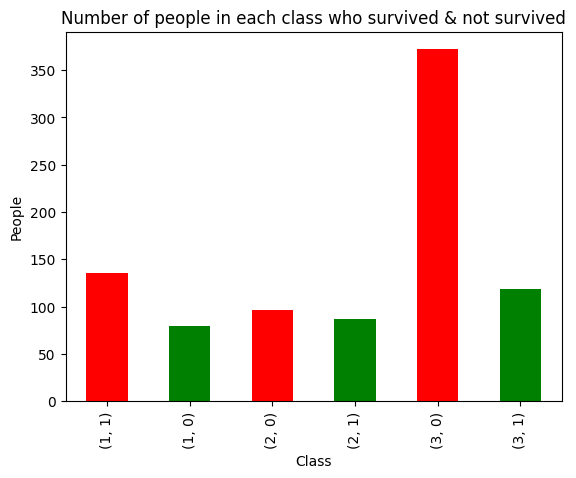

In [41]:
titanic_tools.plot_who_survived(titanic_train)

<span style="color:orange;font-size:30px">4. Data preparation</span>

Handle NaN values

In [42]:
titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [43]:
missing_values_handler = titanic_tools.MissingValuesHandler(titanic_train)
missing_values_handler.fill_embarked()
missing_values_handler.fill_age()
missing_values_handler.drop_columns()
titanic_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [44]:
titanic_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [45]:
passengers_id_test_set = titanic_test.PassengerId

In [46]:
missing_values_handler = titanic_tools.MissingValuesHandler(titanic_test)
missing_values_handler.fill_embarked()
missing_values_handler.fill_age()
missing_values_handler.fill_fare()
missing_values_handler.drop_columns()
titanic_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Encoding

In [47]:
titanic_train = titanic_tools.encode_data(titanic_train)
titanic_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [48]:
titanic_test = titanic_tools.encode_data(titanic_test)
titanic_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0


Scaling

In [49]:
sc = StandardScaler()
titanic_train[["Age", "Fare"]] = sc.fit_transform(titanic_train[["Age", "Fare"]])
titanic_test[["Age", "Fare"]] = sc.transform(titanic_test[["Age", "Fare"]])


In [50]:
titanic_train_labels = titanic_tools.get_labels(titanic_train)
titanic_train_features = titanic_tools.get_features(titanic_train)

In [51]:
titanic_test

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0.394887,0,0,-0.490783,0.0,1.0,0.0,1.0,0.0
1,3,1.355510,1,0,-0.507479,1.0,0.0,0.0,0.0,1.0
2,2,2.508257,0,0,-0.453367,0.0,1.0,0.0,1.0,0.0
3,3,-0.181487,0,0,-0.474005,0.0,1.0,0.0,0.0,1.0
4,3,-0.565736,1,1,-0.401017,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,3,-0.181487,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0
414,1,0.740711,0,0,1.544246,1.0,0.0,1.0,0.0,0.0
415,3,0.702286,0,0,-0.502445,0.0,1.0,0.0,0.0,1.0
416,3,-0.181487,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0


<span style="color:orange;font-size:30px">5. Training & Tune the Model</span>

In [52]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(titanic_train_features, titanic_train_labels)

SGDClassifier(random_state=42)

In [53]:
result = cross_val_score(sgd_clf, titanic_train_features, titanic_train_labels, cv=3, scoring="accuracy")
result

array([0.74747475, 0.77777778, 0.77441077])

In [54]:
prediction = cross_val_predict(sgd_clf, titanic_train_features, titanic_train_labels, cv=3)
confusion_matrix(titanic_train_labels, prediction)


array([[454,  95],
       [113, 229]], dtype=int64)

In [55]:
print(precision_score(titanic_train_labels, prediction))
print(recall_score(titanic_train_labels, prediction))
print(f1_score(titanic_train_labels, prediction))

0.7067901234567902
0.6695906432748538
0.6876876876876877


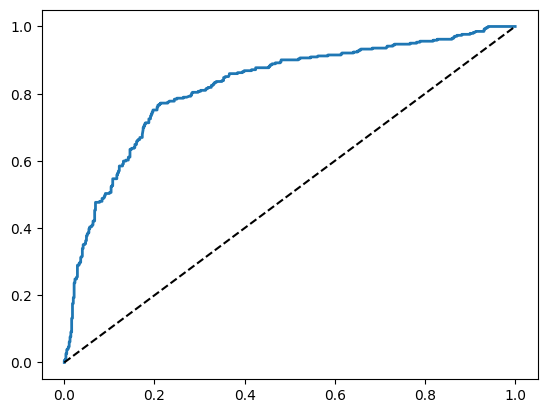

In [56]:
y_scores = cross_val_predict(sgd_clf, titanic_train_features, titanic_train_labels, cv=3, method="decision_function")
fpr, tpr, tresholds = roc_curve(titanic_train_labels, y_scores)
plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [57]:
roc_auc_score(titanic_train_labels, y_scores)

0.8210675443922496

RANDOM FOREST

In [58]:
forest_clf = RandomForestClassifier(random_state=42, n_estimators = 5000)
y_probas_forest = cross_val_predict(forest_clf, titanic_train_features, titanic_train_labels, cv=3, method="predict_proba")

In [59]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, tresholds_forest = roc_curve(titanic_train_labels, y_scores_forest)

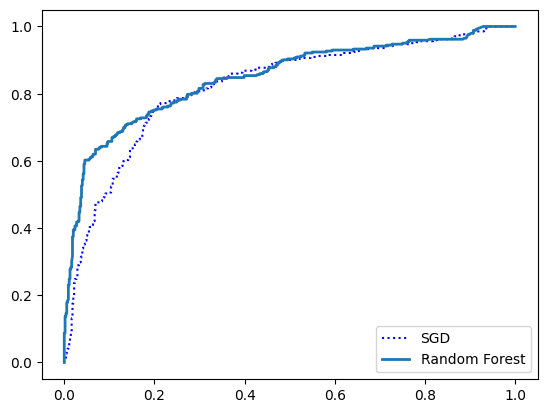

In [60]:
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.legend(loc="lower right")
plt.show()

In [61]:
print(roc_auc_score(titanic_train_labels, y_scores_forest))

0.8468027993480971


In [62]:
prediction = cross_val_predict(forest_clf, titanic_train_features, titanic_train_labels, cv=3)

In [63]:
print(precision_score(titanic_train_labels, prediction))
print(recall_score(titanic_train_labels, prediction))
print(f1_score(titanic_train_labels, prediction))

0.7379518072289156
0.716374269005848
0.7270029673590505


SVC

In [64]:
svc = svm.SVC()
svc.fit(titanic_train_features, titanic_train_labels)

SVC()

In [65]:
y_scores_svc = cross_val_predict(svc, titanic_train_features, titanic_train_labels, cv=4, method="decision_function")
print(roc_auc_score(titanic_train_labels, y_scores_svc))

0.84525026896324


In [66]:
roc_auc_score(titanic_train_labels, y_scores)

0.8210675443922496

<span style="color:orange;font-size:30px">6. Solution presentation & save</span>

In [67]:
solution = svc.predict(titanic_test)

In [68]:
df = pd.DataFrame({'PassengerId': passengers_id_test_set, 'Survived': solution})
df.to_csv("./results/titanic_results.csv", index=False)